## Import packages

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Read and preprocess the data

The daily data

In [2]:
# Loading/Reading in the Data
df = pd.read_csv("BTC_daily.csv")

In [3]:
df['Diff_Close'] = df['Close'].diff()

In [4]:
# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 300 closing prices.
df_daily = df.set_index("Date")[['Diff_Close']].tail(300)
df_daily = df_daily.set_index(pd.to_datetime(df_daily.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df_daily = pd.DataFrame(scaler.fit_transform(df_daily), columns=df_daily.columns, index=df_daily.index)
df_daily

,Diff_Close
Date,
2021-08-04,0.656026
2021-08-05,0.614235
2021-08-06,0.687197
2021-08-07,0.668831
2021-08-08,0.447973
...,...
2022-05-26,0.488886
2022-05-27,0.458413
2022-05-28,0.531559


The hourly data

In [5]:
df2 = pd.read_csv("BTC_hourly.csv", header = 1)
df2 = df2.iloc[::-1].reset_index(drop=True)

In [6]:
df2['Diff_Close'] = df2['close'].diff()

In [7]:
# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 300 closing prices.
df_hourly = df2.set_index("date")[['Diff_Close']].tail(300)
df_hourly = df_hourly.set_index(pd.to_datetime(df_hourly.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df_hourly = pd.DataFrame(scaler.fit_transform(df_hourly), columns=df_hourly.columns, index=df_hourly.index)
df_hourly['Diff_Close'] = df_hourly['Diff_Close'].fillna(0)
df_hourly

,Diff_Close
date,
2022-05-17 13:00:00,0.545486
2022-05-17 14:00:00,0.288440
2022-05-17 15:00:00,0.649248
2022-05-17 16:00:00,0.594802
2022-05-17 17:00:00,0.554104
...,...
2022-05-29 20:00:00,0.632421
2022-05-29 21:00:00,0.628317
2022-05-29 22:00:00,0.729891


## Functions to use for visualizing the result, splitting data, and layer making

In [8]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,6))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(history['val_rmse'])
    plt.plot(history['rmse'])
    plt.legend(['val_rmse', 'rmse'])
    plt.title('RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.show()
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    creates two arrays: X and y. 
    These variables are the input and output variables respectively for our Neural Network. 
    The input is the number of periods to look back and the output is the number of periods ahead. 
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def layer_maker(model, n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1, n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

## Functions to create our Recurrent Neural Network--LSTM

In [9]:
def init_model() :
    # Instantiating the model
    model = Sequential()

    # Activation
    activ = "softsign"

    # Input layer
    model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

    # Hidden layers
    layer_maker(model, n_layers=12, n_nodes=24, activation=activ, drop=2)

    # Final Hidden layer
    model.add(LSTM(10, activation=activ))

    # Output layer
    model.add(Dense(n_per_out))

    # Model summary
    model.summary()
    return model

## Model parameters and period units

The daily model

In [10]:
"""
We choose to look back on 30 days of price history to predict the next 10 days.
"""

# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X_daily, y_daily = split_sequence(list(df_daily.Diff_Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_daily = X_daily.reshape((X_daily.shape[0], X_daily.shape[1], n_features))
print(X_daily.shape, y_daily.shape)

(261, 30, 1) (261, 10)


The hourly model

In [11]:
"""
We choose to look back on 30 hours of price history to predict the next 10 hours.
"""

# Splitting the data into appropriate sequences
X_hourly, y_hourly = split_sequence(list(df_hourly.Diff_Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_hourly = X_hourly.reshape((X_hourly.shape[0], X_hourly.shape[1], n_features))
print(X_hourly.shape, y_hourly.shape)

(261, 30, 1) (261, 10)


## Fit the model by trying 200 epochs

In [12]:
model = init_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=400,
    decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None),
                       tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)])

2022-06-19 23:59:58.157371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 24)            5280      
                                                                 
 lstm_2 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout (Dropout)           (None, 30, 24)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 24)            4704      
                                                                 
 lstm_4 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout_1 (Dropout)         (None, 30, 24)            0

The daily model

In [13]:
res_daily = model.fit(X_daily, y_daily, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
8/8 [==============================] - 13s 335ms/step - loss: 0.2715 - mean_squared_error: 0.2715 - rmse: 0.5211 - val_loss: 0.2230 - val_mean_squared_error: 0.2230 - val_rmse: 0.4723
Epoch 2/200
8/8 [==============================] - 1s 98ms/step - loss: 0.2385 - mean_squared_error: 0.2385 - rmse: 0.4883 - val_loss: 0.1832 - val_mean_squared_error: 0.1832 - val_rmse: 0.4281
Epoch 3/200
8/8 [==============================] - 1s 106ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - rmse: 0.4397 - val_loss: 0.1354 - val_mean_squared_error: 0.1354 - val_rmse: 0.3679
Epoch 4/200
8/8 [==============================] - 1s 93ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - rmse: 0.3782 - val_loss: 0.0953 - val_mean_squared_error: 0.0953 - val_rmse: 0.3087
Epoch 5/200
8/8 [==============================] - 1s 94ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - rmse: 0.3133 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_rmse: 0.2375
Epoch 6/200
8/8 [==========

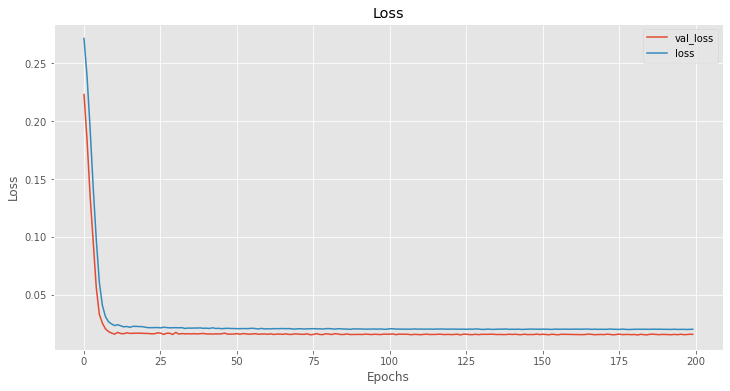

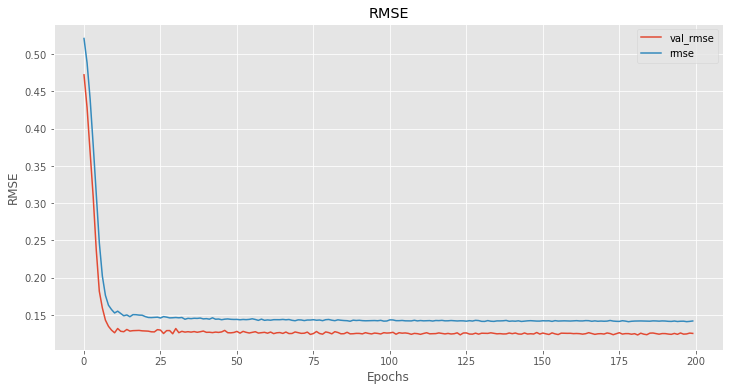

In [14]:
visualize_training_results(res_daily)

The hourly model

In [15]:
res_hourly = model.fit(X_hourly, y_hourly, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
8/8 [==============================] - 1s 86ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - rmse: 0.1362 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_rmse: 0.0497
Epoch 2/200
8/8 [==============================] - 1s 90ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - rmse: 0.1264 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_rmse: 0.0581
Epoch 3/200
8/8 [==============================] - 1s 92ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - rmse: 0.1249 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_rmse: 0.0506
Epoch 4/200
8/8 [==============================] - 1s 87ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - rmse: 0.1247 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_rmse: 0.0509
Epoch 5/200
8/8 [==============================] - 1s 88ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - rmse: 0.1236 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_rmse: 0.0492
Epoch 6/200
8/8 [=============

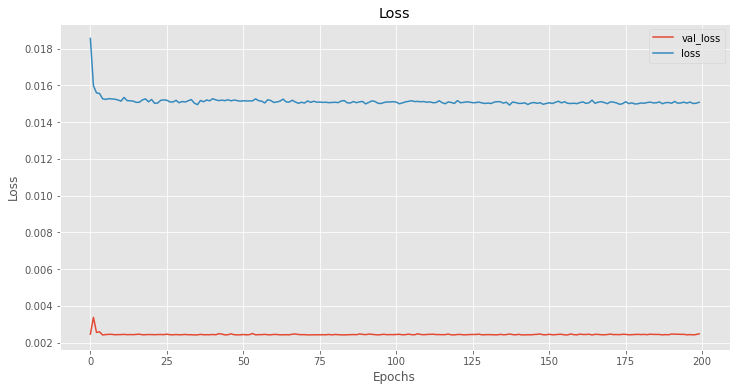

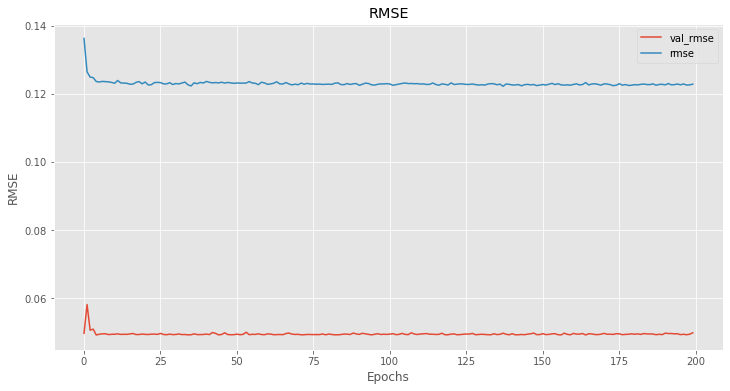

In [16]:
visualize_training_results(res_hourly)

## Test our model with comparison against actual data

for the next ten periods

In [17]:
# Getting predictions of x_daily and transform them back to normal prices
yhat_daily_change = model.predict(X_daily[-1].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_daily_change = scaler.inverse_transform(np.array(yhat_daily_change).reshape(-1,1)).tolist()

# Getting the actual values of y_daily
actual_daily_change = scaler.inverse_transform(y_daily[-1].reshape(-1,1))

print("\nActual Changes for the next 10 days:\n", actual_daily_change.tolist())
print("Predicted Changes for the next 10 days:\n", yhat_daily_change)

# Getting predictions of x_hourly and transform them back to normal prices
yhat_hourly_change = model.predict(X_hourly[-1].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_hourly_change = scaler.inverse_transform(np.array(yhat_hourly_change).reshape(-1,1)).tolist()

# Getting the actual values of y_hourly
actual_hourly_change = scaler.inverse_transform(y_hourly[-1].reshape(-1,1))

print("\nActual Changes for the next 10 hours:\n", actual_hourly_change.tolist())
print("Predicted Changes for the next 10 hours:\n", yhat_hourly_change)

print("\n")


Actual Changes for the next 10 days:
 [[-88.44982340200959], [-3.10163567629549], [-276.76895536295604], [-46.398429627377375], [-130.439338845549], [-156.5493049748176], [-201.09958145615644], [-94.16032887512695], [-36.77997884369467], [176.50676565431186]]
Predicted Changes for the next 10 days:
 [[-4.177413511275498], [-0.3727941989891206], [0.584024858475479], [-0.9118545532219087], [-0.11781673431321726], [-3.787714529036728], [-0.9485413312904512], [3.9950237989433135], [1.0446574211128081], [-7.466849374770371]]

Actual Changes for the next 10 hours:
 [[-78.59999999999853], [66.99999999999993], [-59.900000000001384], [-54.099999999998516], [-44.09999999999853], [53.2999999999992], [47.29999999999934], [195.79999999999924], [36.99999999999999], [-137.50000000000006]]
Predicted Changes for the next 10 hours:
 [[-4.177413511275498], [-0.3727941989891206], [0.5841120004661406], [-0.9118545532219087], [-0.1179910182945405], [-3.7876273870460664], [-0.9485413312904512], [3.995023798

In [18]:
# turn the change into prices by adding them to the former
actual_daily = df['Close'].tail(1).tolist()
for change in actual_daily_change.tolist():
    actual_daily.append(actual_daily[-1] + change[0])
actual_daily = actual_daily[1:]

predicted_daily = df['Close'].tail(1).tolist()
for change in yhat_daily_change:
    predicted_daily.append(predicted_daily[-1] + change[0])
predicted_daily = predicted_daily[1:]

actual_hourly = df2['close'].tail(1).tolist()
for change in actual_hourly_change.tolist():
    actual_hourly.append(actual_hourly[-1] + change[0])
actual_hourly = actual_hourly[1:]

predicted_hourly = df2['close'].tail(1).tolist()
for change in yhat_hourly_change:
    predicted_hourly.append(predicted_hourly[-1] + change[0])
predicted_hourly = predicted_hourly[1:]

# turn the list into a list of list and print
actual_daily = [[ele] for ele in actual_daily]
predicted_daily = [[ele] for ele in predicted_daily]
actual_hourly = [[ele] for ele in actual_hourly]
predicted_hourly = [[ele] for ele in predicted_hourly]

print("\nActual Prices for the next 10 days:\n", actual_daily)
print("Predicted Prices for the next 10 days:\n", predicted_daily)

print("\nActual Prices for the next 10 hours:\n", actual_hourly)
print("Predicted Prices for the next 10 hours:\n", predicted_hourly)

print("\n")


Actual Prices for the next 10 days:
 [[31637.94080159799], [31634.839165921694], [31358.070210558737], [31311.67178093136], [31181.23244208581], [31024.68313711099], [30823.583555654834], [30729.423226779705], [30692.643247936012], [30869.150013590322]]
Predicted Prices for the next 10 days:
 [[31722.213211488724], [31721.840417289735], [31722.42444214821], [31721.51258759499], [31721.394770860676], [31717.60705633164], [31716.65851500035], [31720.65353879929], [31721.698196220404], [31714.231346845634]]

Actual Prices for the next 10 hours:
 [[29236.7], [29303.7], [29243.8], [29189.7], [29145.600000000002], [29198.9], [29246.2], [29442.0], [29479.0], [29341.5]]
Predicted Prices for the next 10 hours:
 [[29311.122586488724], [29310.749792289735], [29311.3339042902], [29310.42204973698], [29310.304058718684], [29306.516431331638], [29305.567890000348], [29309.56291379929], [29310.607571220404], [29303.140634703643]]




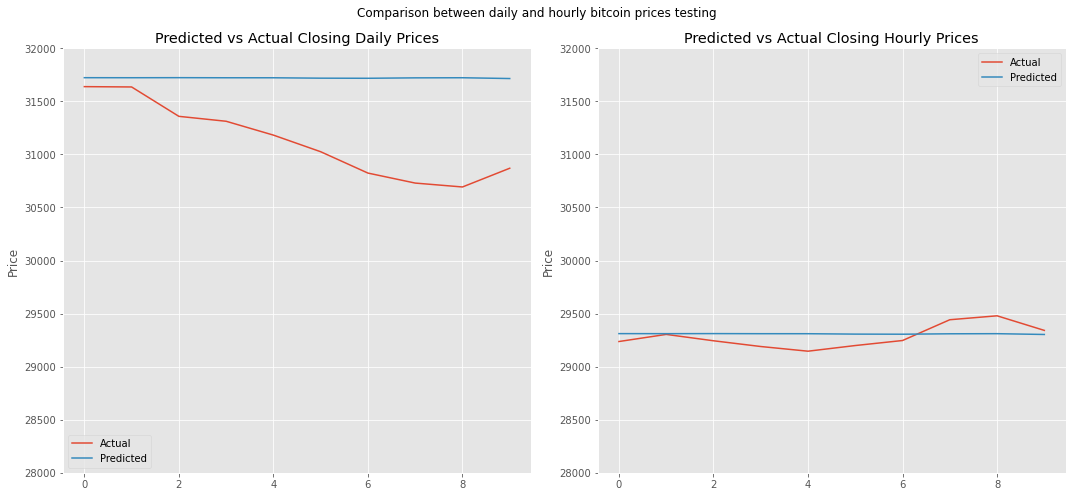

In [19]:
fig = plt.figure()
fig.set_size_inches(15, 7)
fig.suptitle("Comparison between daily and hourly bitcoin prices testing")

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim([28000, 32000])
ax1.plot(actual_daily, label='Actual')
ax1.plot(predicted_daily, label='Predicted')
ax1.set_title(f"Predicted vs Actual Closing Daily Prices")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylim([28000, 32000])
ax2.plot(actual_hourly, label='Actual')
ax2.plot(predicted_hourly, label='Predicted')
ax2.set_title(f"Predicted vs Actual Closing Hourly Prices")
ax2.set_ylabel("Price")
ax2.legend()

plt.tight_layout()

for the last ten periods

In [20]:
# Getting predictions of x_daily and transform them back to normal prices
yhat_daily_change_random = model.predict(X_daily[-31].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_daily_change_random = scaler.inverse_transform(np.array(yhat_daily_change_random).reshape(-1,1)).tolist()

# Getting the actual values of y_daily
actual_daily_change_random = scaler.inverse_transform(y_daily[-31].reshape(-1,1))

print("\nActual Changes for the last 10 days:\n", actual_daily_change_random.tolist())
print("Predicted Changes for the last 10 days:\n", yhat_daily_change_random)

# Getting predictions of x_hourly and transform them back to normal prices
yhat_hourly_change_random = model.predict(X_hourly[-31].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_hourly_change_random = scaler.inverse_transform(np.array(yhat_hourly_change_random).reshape(-1,1)).tolist()

# Getting the actual values of y_hourly
actual_hourly_change_random = scaler.inverse_transform(y_hourly[-31].reshape(-1,1))

print("\nActual Changes for the last 10 hours:\n", actual_hourly_change_random.tolist())
print("Predicted Changes for the last 10 hours:\n", yhat_hourly_change_random)

print("\n")


Actual Changes for the last 10 days:
 [[-227.91471051925697], [-220.15943496541576], [-151.17673220342894], [-120.63904066167342], [9.508958557367295], [-421.0873930562273], [26.920317199069526], [-49.497913258499736], [-268.9055818507289], [-234.11317242425432]]
Predicted Changes for the last 10 days:
 [[-4.177413511275498], [-0.3727941989891206], [0.5841120004661406], [-0.9118545532219087], [-0.11781673431321726], [-3.7876273870460664], [-0.9485413312904512], [3.9950237989433135], [1.0446574211128081], [-7.466936516761033]]

Actual Changes for the last 10 hours:
 [[-29.500000000000004], [6.900000000001395], [15.79999999999928], [152.2999999999993], [96.0], [-121.1999999999971], [29.79999999999922], [24.299999999999294], [-117.20000000000071], [105.70000000000077]]
Predicted Changes for the last 10 hours:
 [[-4.177413511275498], [-0.3727941989891206], [0.5841120004661406], [-0.9118545532219087], [-0.1179910182945405], [-3.7876273870460664], [-0.9485413312904512], [3.9950237989433135]

In [21]:
# turn the change into prices by adding them to the former
actual_daily_random = df['Close'].iloc[[-31]].tolist() #取倒数第31行

for change in actual_daily_change_random.tolist():
    actual_daily_random.append(actual_daily_random[-1] + change[0])
actual_daily_random = actual_daily_random[1:]

predicted_daily_random = df['Close'].iloc[[-31]].tolist()
for change in yhat_daily_change_random:
    predicted_daily_random.append(predicted_daily_random[-1] + change[0])
predicted_daily_random = predicted_daily_random[1:]

actual_hourly_random = df2['close'].iloc[[-31]].tolist()
for change in actual_hourly_change_random.tolist():
    actual_hourly_random.append(actual_hourly_random[-1] + change[0])
actual_hourly_random = actual_hourly_random[1:]

predicted_hourly_random = df2['close'].iloc[[-31]].tolist()
for change in yhat_hourly_change_random:
    predicted_hourly_random.append(predicted_hourly_random[-1] + change[0])
predicted_hourly_random = predicted_hourly_random[1:]

# turn the list into a list of list and print
actual_daily_random = [[ele] for ele in actual_daily_random]
predicted_daily_random = [[ele] for ele in predicted_daily_random]
actual_hourly_random = [[ele] for ele in actual_hourly_random]
predicted_hourly_random = [[ele] for ele in predicted_hourly_random]

print("\nActual Prices for the last 10 days:\n", actual_daily_random)
print("Predicted Prices for the last 10 days:\n", predicted_daily_random)

print("\nActual Prices for the last 10 hours:\n", actual_hourly_random)
print("Predicted Prices for the last 10 hours:\n", predicted_hourly_random)

print("\n")


Actual Prices for the last 10 days:
 [[37486.96028948074], [37266.80085451532], [37115.62412231189], [36994.98508165022], [37004.49404020759], [36583.40664715136], [36610.326964350425], [36560.829051091925], [36291.9234692412], [36057.81029681695]]
Predicted Prices for the last 10 days:
 [[37710.69758648873], [37710.32479228974], [37710.90890429021], [37709.997049736994], [37709.879233002684], [37706.09160561564], [37705.143064284355], [37709.1380880833], [37710.18274550442], [37702.71580898766]]

Actual Prices for the last 10 hours:
 [[28958.0], [28964.9], [28980.7], [29133.0], [29229.0], [29107.800000000003], [29137.600000000002], [29161.9], [29044.7], [29150.4]]
Predicted Prices for the last 10 hours:
 [[28983.322586488724], [28982.949792289735], [28983.5339042902], [28982.62204973698], [28982.504058718685], [28978.71643133164], [28977.76789000035], [28981.76291379929], [28982.807571220404], [28975.340634703643]]




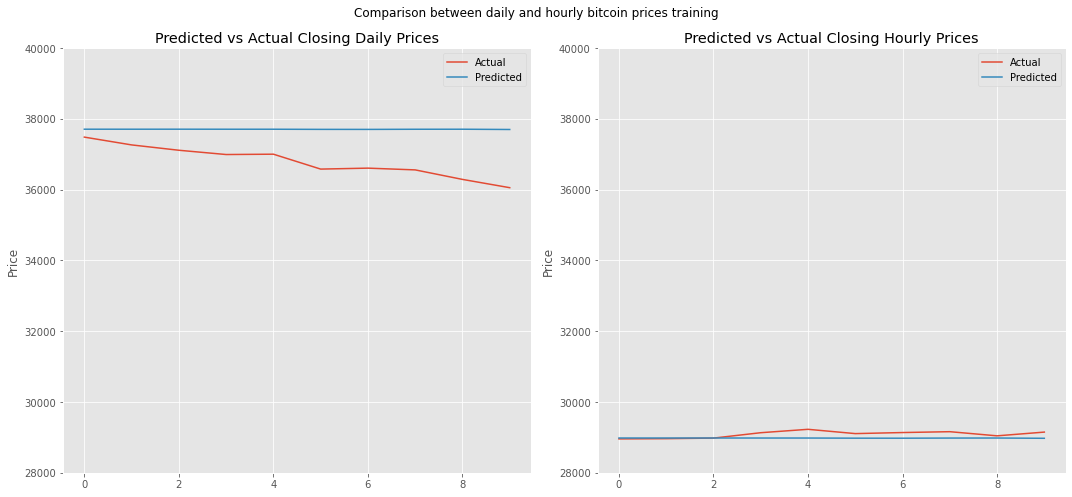

In [22]:
fig = plt.figure()
fig.set_size_inches(15, 7)
fig.suptitle("Comparison between daily and hourly bitcoin prices training")

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim([28000, 40000])
ax1.plot(actual_daily_random, label='Actual')
ax1.plot(predicted_daily_random, label='Predicted')
ax1.set_title(f"Predicted vs Actual Closing Daily Prices")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylim([28000, 40000])
ax2.plot(actual_hourly_random, label='Actual')
ax2.plot(predicted_hourly_random, label='Predicted')
ax2.set_title(f"Predicted vs Actual Closing Hourly Prices")
ax2.set_ylabel("Price")
ax2.legend()

plt.tight_layout()

## Use our model to forecast the future changes of Bitcoin

input the last 30 days worth of prices in our model.predict() method and predict Bitcoin prices for the next 10 days

In [23]:
df = df.set_index("Date")[['Close']].tail(300)
df = df.set_index(pd.to_datetime(df.index))

            Diff_Close
2022-05-30   -4.177414
2022-05-31   -0.372794
2022-06-01    0.584112
2022-06-02   -0.911855
2022-06-03   -0.117817
2022-06-04   -3.787627
2022-06-05   -0.948541
2022-06-06    3.995024
2022-06-07    1.044570
2022-06-08   -7.466937


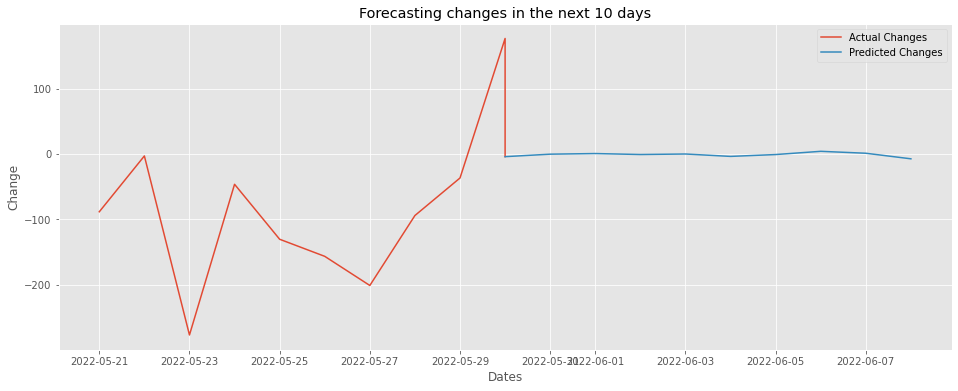

In [24]:
# Predicting daily future values and transforming to non-normal
yhat_future_daily_change = model.predict(np.array(df_daily.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
yhat_future_daily_change = scaler.inverse_transform(np.array(yhat_future_daily_change).reshape(-1,1)).tolist()

# Creating a dataframe of the predicted changes
preds_future_daily_change = pd.DataFrame(yhat_future_daily_change, index=pd.date_range(start=df_daily.index[-1], periods=len(yhat_future_daily_change), freq="D"),
                           columns=df_daily.columns)

# Printing the predicted changes
print(preds_future_daily_change)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original change
actual_future_daily_change = pd.DataFrame(scaler.inverse_transform(df_daily[["Diff_Close"]].tail(pers)), index=df_daily.Diff_Close.tail(pers).index,
                                   columns=df_daily.columns).append(preds_future_daily_change.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_daily_change, label="Actual Changes")
plt.plot(preds_future_daily_change, label="Predicted Changes")
plt.ylabel("Change")
plt.xlabel("Dates")
plt.title(f"Forecasting changes in the next {len(yhat_future_daily_change)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

                   Close
2022-05-30  31722.213211
2022-05-31  31721.840417
2022-06-01  31722.424529
2022-06-02  31721.512675
2022-06-03  31721.394858
2022-06-04  31717.607231
2022-06-05  31716.658689
2022-06-06  31720.653713
2022-06-07  31721.698283
2022-06-08  31714.231347


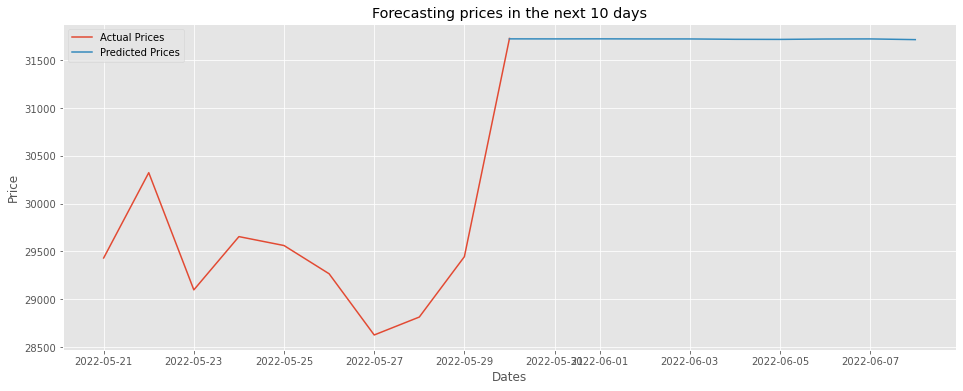

In [25]:
# turn the change into prices by adding them to the former
pred_future_daily = df['Close'].tail(1).tolist()
for change in yhat_future_daily_change:
    pred_future_daily.append(pred_future_daily[-1] + change[0])
pred_future_daily = pred_future_daily[1:]
pred_future_daily = [[ele] for ele in pred_future_daily]

# Creating a dataframe of the predicted prices
preds_future_daily = pd.DataFrame(pred_future_daily, index=pd.date_range(start=df.index[-1], periods=len(pred_future_daily), freq="D"),
                           columns=df.columns)

# Printing the predicted prices
print(preds_future_daily)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual_future_daily = df.tail(10)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_daily, label="Actual Prices")
plt.plot(preds_future_daily, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting prices in the next {len(pred_future_daily)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

input the last 30 hours worth of prices in our model.predict() method and predict Bitcoin prices for the next 10 hours

In [26]:
df2 = df2.set_index("date")[['close']].tail(300)
df2 = df2.set_index(pd.to_datetime(df2.index))

                     Diff_Close
2022-05-30 00:00:00   -4.177414
2022-05-30 01:00:00   -0.372794
2022-05-30 02:00:00    0.584112
2022-05-30 03:00:00   -0.911855
2022-05-30 04:00:00   -0.117817
2022-05-30 05:00:00   -3.787627
2022-05-30 06:00:00   -0.948541
2022-05-30 07:00:00    3.995024
2022-05-30 08:00:00    1.044657
2022-05-30 09:00:00   -7.466937


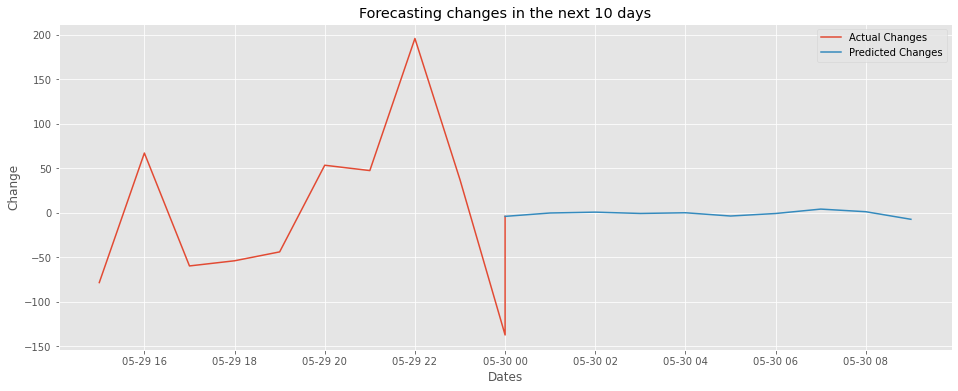

In [27]:
# Predicting hourly future values and transforming to non-normal
yhat_future_hourly_change = model.predict(np.array(df_hourly.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
yhat_future_hourly_change = scaler.inverse_transform(np.array(yhat_future_hourly_change).reshape(-1,1)).tolist()

# Creating a dataframe of the predicted changes
preds_future_hourly_change = pd.DataFrame(yhat_future_hourly_change, index=pd.date_range(start=df_hourly.index[-1], periods=len(yhat_future_hourly_change), freq="1H"),
                           columns=df_hourly.columns)

# Printing the predicted changes
print(preds_future_hourly_change)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original change
actual_future_hourly_change = pd.DataFrame(scaler.inverse_transform(df_hourly[["Diff_Close"]].tail(pers)), index=df_hourly.Diff_Close.tail(pers).index,
                                   columns=df_hourly.columns).append(preds_future_hourly_change.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_hourly_change, label="Actual Changes")
plt.plot(preds_future_hourly_change, label="Predicted Changes")
plt.ylabel("Change")
plt.xlabel("Dates")
plt.title(f"Forecasting changes in the next {len(yhat_future_hourly_change)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

                            close
2022-05-30 00:00:00  29311.122586
2022-05-30 01:00:00  29310.749792
2022-05-30 02:00:00  29311.333904
2022-05-30 03:00:00  29310.422050
2022-05-30 04:00:00  29310.304233
2022-05-30 05:00:00  29306.516606
2022-05-30 06:00:00  29305.568064
2022-05-30 07:00:00  29309.563088
2022-05-30 08:00:00  29310.607746
2022-05-30 09:00:00  29303.140809


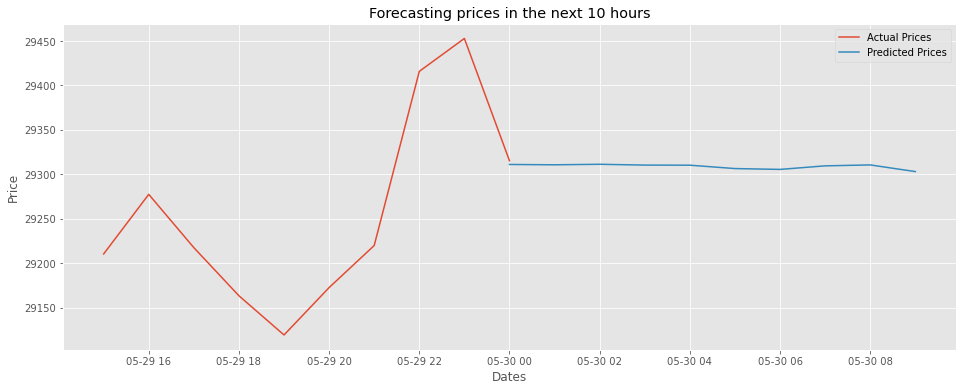

In [28]:
# turn the change into prices by adding them to the former
pred_future_hourly = df2['close'].tail(1).tolist()
for change in yhat_future_hourly_change:
    pred_future_hourly.append(pred_future_hourly[-1] + change[0])
pred_future_hourly = pred_future_hourly[1:]
pred_future_hourly = [[ele] for ele in pred_future_hourly]

# Creating a dataframe of the predicted prices
preds_future_hourly = pd.DataFrame(pred_future_hourly, index=pd.date_range(start=df2.index[-1], periods=len(pred_future_hourly), freq="1H"),
                           columns=df2.columns)

# Printing the predicted prices
print(preds_future_hourly)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual_future_hourly = df2.tail(10)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_hourly, label="Actual Prices")
plt.plot(preds_future_hourly, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting prices in the next {len(preds_future_hourly)} hours")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()